In [1]:
from math_utils import *
from plot_utils import *
from low_rank_approximation import *

In [2]:
# compute_global_stats_df()

# Checking possible errors
The following are execution that measured only one iteration, they can be error. We will check if they are.

In [3]:
filter = {'iteration': lambda x: x == 1}
plot_agg_global_df(x='t_name', y='m_name', filter=filter, logscale=(False, False))

the first 334-12 execution with only 1 iteration are all mnist matrices, few of them are 27x27 matrices, the others are 250x250 matrices obtained scaling the original 27x27 handwritten digit. They are for whure low ranak, so the convergence can be istantaneous if k is high enough.

In [4]:
# Assuming global_df is your DataFrame and it has a column named 'obj_fun'
global_df = load_global_df(filter)

# Sort the DataFrame by the 'obj_fun' column
sorted_df = global_df.sort_values(by='obj_fun')

# Display the sorted DataFrame
sorted_df.tail(20)[['c_name', 'm_name', 't_name', 'obj_fun']].reset_index()

index     c_name                  m_name                     t_name  \
0    1504      mnist      250x250_5_6405.png          50_scaled_u_1e-08   
1    1616      mnist      250x250_6_4211.png          50_scaled_u_1e-08   
2    1500      mnist      250x250_5_6405.png            50_rand_u_1e-08   
3    1184      mnist      250x250_3_2594.png  100_semi-orthogonal_1e-08   
4    1728      mnist      250x250_7_1496.png          50_scaled_u_1e-08   
5    1286      mnist      250x250_3_4044.png       50_sketching_g_1e-08   
6    1724      mnist      250x250_7_1496.png            50_rand_u_1e-08   
7    1244      mnist      250x250_3_4044.png      100_sketching_g_1e-08   
8     250   diagonal  eighen_bad_bad_100x100        1_sketching_g_1e-08   
9     248   diagonal  eighen_bad_bad_100x100        1_sketching_b_1e-08   
10    320   diagonal  eighen_bad_bad_250x250        1_sketching_g_1e-08   
11    318   diagonal  eighen_bad_bad_250x250        1_sketching_b_1e-08   
12    136   diagonal      eighen_bad_100x100        1_sketching_b_1e-08   
13    138   diagonal      eighen_bad_100x100        1_sketching_g_1e-08   
14   3216  symmetric      eighen_bad_100x100        1_sketching_b_1e-08   
15   3218  symmetric      eighen_bad_100x100        1_sketching_g_1e-08   
16    208   diagonal      eighen_bad_250x250        1_sketching_g_1e-08   
17   3286  symmetric      eighen_bad_250x250        1_sketching_b_1e-08   
18    206   diagonal      eighen_bad_250x250        1_sketching_b_1e-08   
19   3288  symmetric      eighen_bad_250x250        1_sketching_g_1e-08   

         obj_fun  
0   5.383437e-10  
1   5.773569e-10  
2   6.179759e-10  
3   2.229563e-09  
4   3.870567e-09  
5   6.275286e-09  
6   6.902173e-09  
7   8.848519e-09  
8   5.690308e+01  
9   5.690308e+01  
10  1.134350e+02  
11  1.134350e+02  
12  1.000016e+04  
13  1.000016e+04  
14  1.000016e+04  
15  1.000016e+04  
16  1.000064e+04  
17  1.000064e+04  
18  1.000064e+04  
19  1.000064e+04

as we see, the first 334-12 (considering the obj_fun value) are all good reconstruction of A, so they are not error

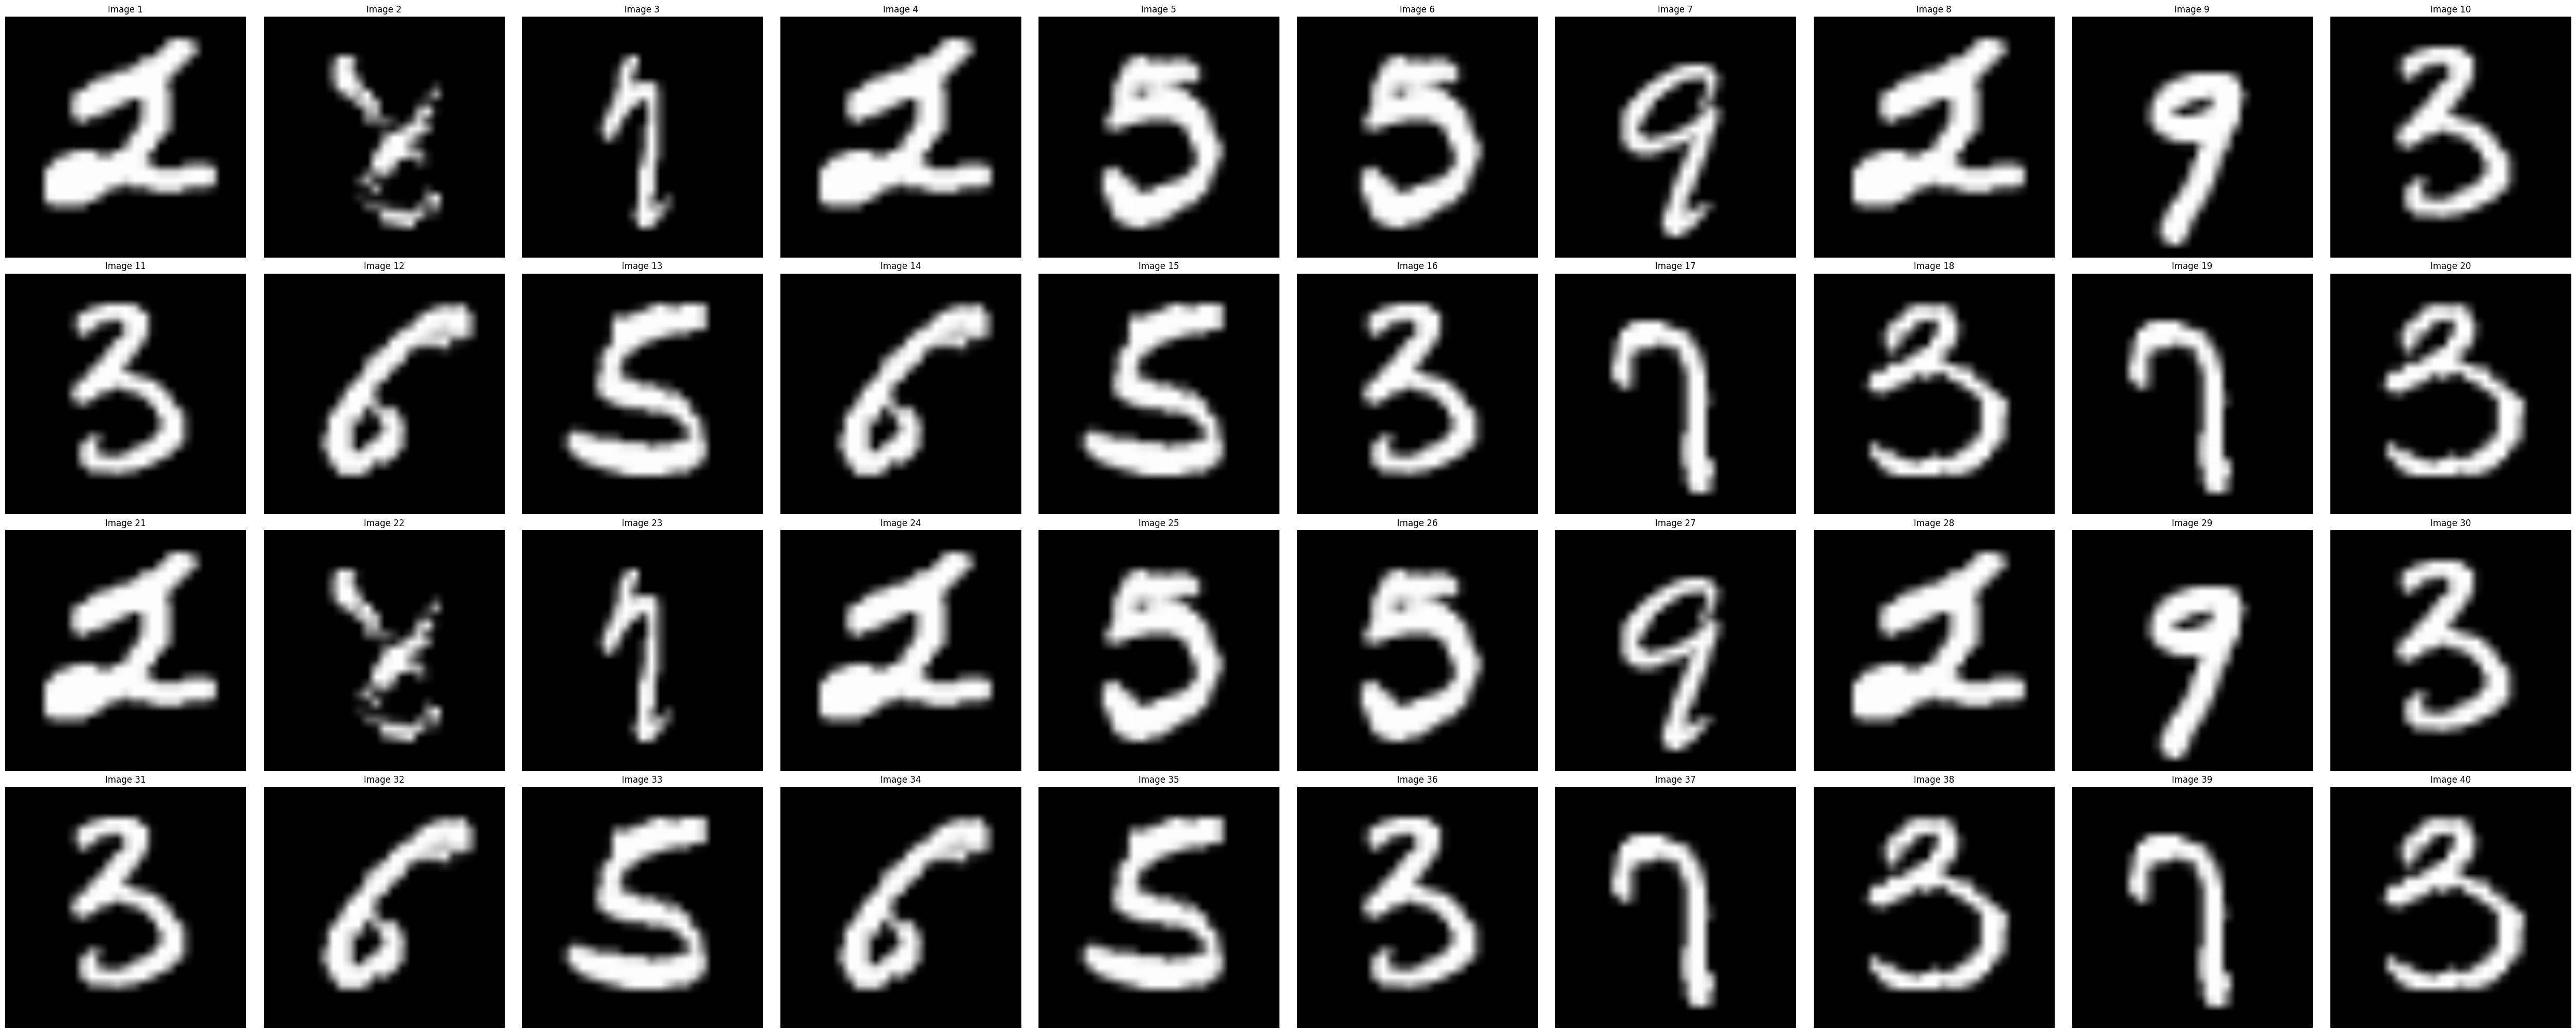

In [5]:
mats = [load_matrices(row['c_name'], row['m_name'], row['t_name']) for index, row in sorted_df.iloc[-32:-12].iterrows()]
show_grayscale_images([m['A'] for m in mats] + [m['U'] @ m['V'].transpose() for m in mats], 10)

In [6]:
# rerun(sorted_df.iloc[-2]['c_name'], sorted_df.iloc[-1]['m_name'], sorted_df.iloc[-2]['t_name'], changes={'k':10})

In [7]:
# rerun(sorted_df.iloc[-2]['c_name'], sorted_df.iloc[-2]['m_name'], sorted_df.iloc[-2]['t_name'], changes={'k':10})

after some testing it is evident that they are not error, are indeed good approximation computed with low k values, that generate an high objective function, now we will check other execution with low iteration > 1, not mnist and k > 1

In [8]:
filter = {'iteration': lambda x: (x > 1) & (x < 10), 'c_name': lambda x: (x != 'mnist')}
plot_agg_global_df(x='t_name', y='m_name', filter=filter, logscale=(False, False))

they all have k = 1 so for now we will assume that the algorithm always converge

# Analysis of Epsilon and Initialization Methods

In [9]:
filter = {}
plot_agg_global_df(x='c_name', y='epsilon', filter=filter, logscale=(False, True))

In [10]:
filter = {}
plot_agg_global_df(x='c_name', y='init_method', filter=filter, logscale=(False, False))

## epsilon
il vlore di epsilon cosa influenza?
- convergenza: Non saprei
- numero iterazioni passa da 55-65 a 150 circa
- tempo esecuzione singolo step:
    - qr_time (rand_n, scaled_n, scaled_u)
    - manip (rand_u, semi-orth)
    - bw (rand_u, scaled_u, semi-orth)
- U_norm per sketching gaussiano (var molto grande, strano)
- V_norm methodi uniformi (var molto grande)

### Dopo aver sistemato meglio i grafici:
- Il valore di epsilon influenzi molto e in tutti i test il numero di iterazioni che passano da 140 a 360 se epsilon va da 1e-08 a 10e-16 (media "ponderata" per bilanciare le molte esecuzioni del mnist). 
- Tempi di esecuzione sono quasi identici e non seguono alcun trend indistinguibile.
- Valore della funzione obbiettivo non varia con epsilon.
- Per qualche motivo, solo per il mnist, la distanza tra le due norme è influenzata da epsilon, ma questo non sembra apportare nessun vantaggio svantaggio se non una possibile maggiorata instabilità numerica.

D'ora in poi testeremo solamente con epsilon = 1e-08 sia per risparmiare tempo e risorse, sia perchè ci aiuta ad individuare velocemente situazioni di non convergenza (la più alta precisione potrebbe allungare ma di poco il numero di iterazioni rendendo sol più difficile individuare i problemi)


## Init methods
- per pochi test alcune norme erano spaziali, bisogna capire magari perchè ma mai per sketchin_b e rand_n, solo uno per sketching_g
- sketching e scaled tendono ad avere U norm circa V norm
- exec_time semi-orth lento, rand_n

### Dopo aver sistemato meglio i grafici:
- molta poca, quasi nulla, influenza sul numero di iterazioni, da notare però che il min lo raggiunge sketching_g e il max rand_u e scaled_u che sono "stranamente" più alti (di 10 circa su 160-170) rispetto a tutti gli altri
- il tempo di esecuzione è influenzato di poco e come sempre dipende principalmente da A e k, ma semi-orth ha performance instabili essendo il migliore per mnist ma peggiore per horses. Guardando i tempi delle singole fasi, notiamo che l'instabilità è generata dalla qr e dalla bw. Inoltre fa leggermente meglio degli altri rand_n e sketching_g
- funzione obbiettivo è abbastanza costante tra i test e i metodi.
- per norme di U, V e differenza abbiamo che i metodi si differenziano molto con semi-orth il metodo con la differenza maggiore,sketching_b ( e non il g! ) con la differenza minore di un buon margine medio e rand_n seconda migliore con comunque un ottimo risultato e un possibile miglioramento se necessario, scalando la matrice all'inizializzazione (non generandola con gamma diverso).


# Other analysis

Grandi analisi da fare su performance dell'algoritmo rispetto a k e m*n sia per iterazioni sia per tempo di esecuzione sulle singole fasi sia su funzione obbiettivo che differenza tra le norme

In [11]:
filter = {}
plot_agg_global_df(x='m_n', y='k', filter=filter, logscale=(True, True))

In [12]:
global_df = load_global_df({'c_name': lambda x: x == 'horses'})

In [13]:
global_df['mn_product'] = global_df['m'] * global_df['n']
global_df = global_df.sort_values(by='mn_product', ascending=False)
global_df = global_df.head()

In [14]:
cols={'U_norm', 'error'}
plot_dataframe(global_df['c_name'].iloc[0], global_df['m_name'].iloc[0], global_df['t_name'].iloc[0])

In [15]:
plot_multiple_dataframe(global_df['c_name'].values, global_df['m_name'].values, global_df['t_name'].values, col='error')

### TEST INIZIALIZZAZIONE E EPSILON
una e due per tipo di matrici testate, per comprendere il migliore metodo di inzializzazione e testare la convrgenza con epsilon grandi.
così da fissare questi due valori (o limitarli molto) per i test successivi in cui proviamo l'algoritmo su tante matrici diverse per "generalizzare" la convergenza.
- cavalli
- mnist
- mnist 250x250
- random una gaussiana e una uniforme
- colonne evidentemente non indipendenti
- diagonale o tipo diagonale
- simmetriche con autovalori molto distanti in modulo

### TEST SUCCESSIVI:
preso il migliore metodo di inzializzazione fare un test estensivo su tipi di matrici diverse per verificare la convergenza nel caso più generale possibile.
tenendo conto di:
- k
- dimensione e tipo matrici

tipi matrici:
- cavalli
- mnist (mat sparse)
- colonne evidentemente non indipendenti
- identità (cercando di convergere magari perturbandola)
- triangolari uniformi
- studio autovalori
- ortogonali

## Cosine

le matrici simmetriche con tutti autovalori a uno sono identità .. eliminare i test


le matrici simmetriche con tutti autovalori a uno sono identità .. eliminare i test